The telecom operator Interconnect would like to be able to forecast their churn of clients. If it's discovered that a user is planning to leave, they will be offered promotional codes and special plan options. Interconnect's marketing team has collected some of their clientele's personal data, including information about their plans and contracts.

### Interconnect's services

Interconnect mainly provides two types of services:

1. Landline communication. The telephone can be connected to several lines simultaneously.
2. Internet. The network can be set up via a telephone line (DSL, *digital subscriber line*) or through a fiber optic cable.

Some other services the company provides include:

- Internet security: antivirus software (*DeviceProtection*) and a malicious website blocker (*OnlineSecurity*)
- A dedicated technical support line (*TechSupport*)
- Cloud file storage and data backup (*OnlineBackup*)
- TV streaming (*StreamingTV*) and a movie directory (*StreamingMovies*)

The clients can choose either a monthly payment or sign a 1- or 2-year contract. They can use various payment methods and receive an electronic invoice after a transaction.

### Data Description

The data consists of files obtained from different sources:

- `contract.csv` — contract information
- `personal.csv` — the client's personal data
- `internet.csv` — information about Internet services
- `phone.csv` — information about telephone services

In each file, the column `customerID` contains a unique code assigned to each client.

The contract information is valid as of February 1, 2020.

### Data

[final_provider.zip](https://s3-us-west-2.amazonaws.com/secure.notion-static.com/ac39c23b-718e-4cd6-bdaa-85b3a127a457/final_provider.zip)

In [132]:
import pandas as pd
import numpy as np
import seaborn as sns
import datetime as dt
import xgboost as xgb

from functools import reduce
from imblearn.over_sampling import SMOTENC
from matplotlib import pyplot as plt

from sklearn.model_selection import cross_validate
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.metrics import roc_auc_score, f1_score
from sklearn.model_selection import KFold, GridSearchCV

In [77]:
RANDOM_STATE = 42

## EDA & Data Preparation

In [78]:
data_path = 'final_provider/'
contract = pd.read_csv(data_path + 'contract' + '.csv') 
personal = pd.read_csv(data_path + 'personal' + '.csv')
internet = pd.read_csv(data_path + 'internet' + '.csv')
phone = pd.read_csv(data_path + 'phone' + '.csv')

raw_data_dfs = [contract, personal, internet, phone]

for df in raw_data_dfs:
    print(df.head())
    print(df.info())
    print(df.describe())
    print('\n------------------------------------------------------\n')

   customerID   BeginDate              EndDate            Type  \
0  7590-VHVEG  2020-01-01                   No  Month-to-month   
1  5575-GNVDE  2017-04-01                   No        One year   
2  3668-QPYBK  2019-10-01  2019-12-01 00:00:00  Month-to-month   
3  7795-CFOCW  2016-05-01                   No        One year   
4  9237-HQITU  2019-09-01  2019-11-01 00:00:00  Month-to-month   

  PaperlessBilling              PaymentMethod  MonthlyCharges TotalCharges  
0              Yes           Electronic check           29.85        29.85  
1               No               Mailed check           56.95       1889.5  
2              Yes               Mailed check           53.85       108.15  
3               No  Bank transfer (automatic)           42.30      1840.75  
4              Yes           Electronic check           70.70       151.65  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column            Non-Null Cou

In [79]:
contract[contract['TotalCharges'] == ' '].shape

(11, 8)

In [80]:
contract = contract[contract['TotalCharges'] != ' ']

In [81]:
contract['TotalCharges'] = contract['TotalCharges'].astype(float)

/Users/cathyzhuang/Documents/projects/dsci.ve/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [82]:
contract.describe()

,MonthlyCharges,TotalCharges
count,7032.000000,7032.000000
mean,64.798208,2283.300441
std,30.085974,2266.771362
min,18.250000,18.800000
25%,35.587500,401.450000
50%,70.350000,1397.475000
75%,89.862500,3794.737500
max,118.750000,8684.800000


<AxesSubplot:ylabel='Frequency'>

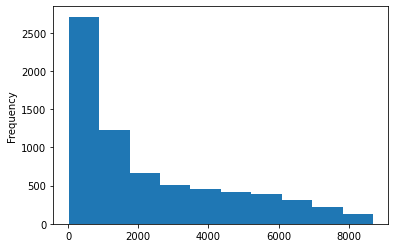

In [83]:
contract['TotalCharges'].plot.hist()

In [84]:
personal['SeniorCitizen'] = np.where(personal['SeniorCitizen'] == 0, 'Yes', 'No')

Aside from the `TotalCharges` which have been dropped, it looks like there are no NULL values across the datasets. Some of the data types have been changed to more appropriate ones.

In [85]:
def deduplicate(df_list):
    for df in df_list:
        print('Row count: ', len(df))
        df.drop_duplicates(inplace=True)
        print('Row count de-duplicated: ', len(df))

In [86]:
deduplicate(raw_data_dfs)

Row count:  7043
Row count de-duplicated:  7043
Row count:  7043
Row count de-duplicated:  7043
Row count:  5517
Row count de-duplicated:  5517
Row count:  6361
Row count de-duplicated:  6361


In [87]:
contract['ended'] = np.where(contract['EndDate'] == 'No', 0, 1)

/Users/cathyzhuang/Documents/projects/dsci.ve/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [88]:
contract.head()

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,ended
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,29.85,0
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,1889.50,0
2,3668-QPYBK,2019-10-01,2019-12-01 00:00:00,Month-to-month,Yes,Mailed check,53.85,108.15,1
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1840.75,0
4,9237-HQITU,2019-09-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,70.70,151.65,1


/Users/cathyzhuang/Documents/projects/dsci.ve/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


Text(0.5, 0, 'Date')

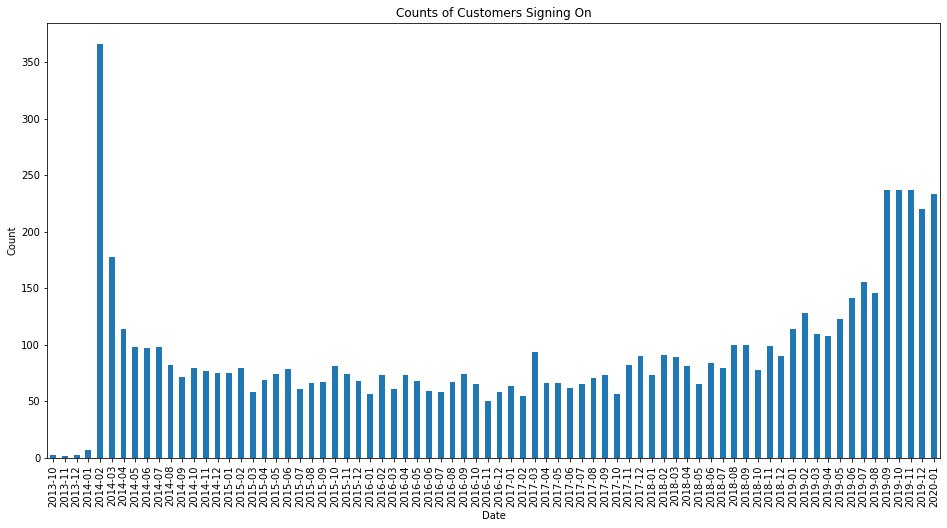

In [89]:
contracts_customer_count = contract[['customerID', 'BeginDate']]
contracts_customer_count['BeginDate'] = pd.to_datetime(contracts_customer_count['BeginDate']).dt.to_period('M')
contracts_customer_count = contracts_customer_count['BeginDate'].value_counts().sort_index()
plt1 = contracts_customer_count.plot(kind='bar', figsize=(16, 8))
plt1.set_title("Counts of Customers Signing On")
plt1.set_ylabel("Count")
plt1.set_xlabel("Date")

Looks like the number of customers signing on (beginning with the company) has the shape of an inverse bell curve - there were a lot of signups in the beginning and towards the end.

Text(0, 0.5, 'Count')

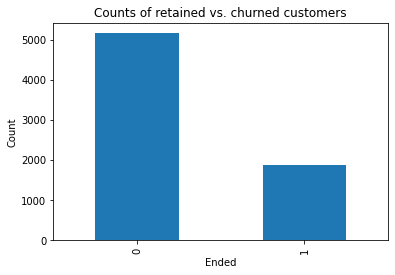

In [90]:
plt2 = contract[['customerID', 'ended']]['ended'].value_counts().plot(kind='bar')
plt2.set_title('Counts of retained vs. churned customers')
plt2.set_xlabel('Ended')
plt2.set_ylabel('Count')

From the above, we can clearly see the class imbalance between retained and churned customers - we have more than 2x retained than churned customers. We will have to adjust for this.

In [91]:
def count_plot_categorical(df, col):
    ax = sns.countplot(x=col, data=df)
    ax.set_title(f'Counts for {col}')

In [92]:
def merge_df_list(df_list, on, how):
    """Merges dataframes from list.

    Args:
        df_list (list): List of dataframes
        join_columns (list): Columns to join on
        how (str): How to join
        suffixes (list): Suffix for left and right dataframes, respectively
    """

    df_merged = reduce(lambda left, right: pd.merge(left, right, 
        on=on, how=how), df_list)
    return df_merged

In [93]:
raw_data_dfs = [contract, personal, internet, phone]
merged = merge_df_list(raw_data_dfs, how='left', on='customerID')

In [94]:
pd.set_option('display.max_columns', 500)
merged.head()

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,ended,gender,SeniorCitizen,Partner,Dependents,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,29.85,0,Female,Yes,Yes,No,DSL,No,Yes,No,No,No,No,NaN
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,1889.50,0,Male,Yes,No,No,DSL,Yes,No,Yes,No,No,No,No
2,3668-QPYBK,2019-10-01,2019-12-01 00:00:00,Month-to-month,Yes,Mailed check,53.85,108.15,1,Male,Yes,No,No,DSL,Yes,Yes,No,No,No,No,No
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1840.75,0,Male,Yes,No,No,DSL,Yes,No,Yes,Yes,No,No,NaN
4,9237-HQITU,2019-09-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,70.70,151.65,1,Female,Yes,No,No,Fiber optic,No,No,No,No,No,No,No


In [95]:
merged.describe()

,MonthlyCharges,TotalCharges,ended
count,7032.000000,7032.000000,7032.000000
mean,64.798208,2283.300441,0.265785
std,30.085974,2266.771362,0.441782
min,18.250000,18.800000,0.000000
25%,35.587500,401.450000,0.000000
50%,70.350000,1397.475000,0.000000
75%,89.862500,3794.737500,1.000000
max,118.750000,8684.800000,1.000000


In [96]:
merged.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7032 entries, 0 to 7031
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7032 non-null   object 
 1   BeginDate         7032 non-null   object 
 2   EndDate           7032 non-null   object 
 3   Type              7032 non-null   object 
 4   PaperlessBilling  7032 non-null   object 
 5   PaymentMethod     7032 non-null   object 
 6   MonthlyCharges    7032 non-null   float64
 7   TotalCharges      7032 non-null   float64
 8   ended             7032 non-null   int64  
 9   gender            7032 non-null   object 
 10  SeniorCitizen     7032 non-null   object 
 11  Partner           7032 non-null   object 
 12  Dependents        7032 non-null   object 
 13  InternetService   5512 non-null   object 
 14  OnlineSecurity    5512 non-null   object 
 15  OnlineBackup      5512 non-null   object 
 16  DeviceProtection  5512 non-null   object 


In [97]:
merged[merged.isnull().any(axis=1)].head(10)

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,ended,gender,SeniorCitizen,Partner,Dependents,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,29.85,0,Female,Yes,Yes,No,DSL,No,Yes,No,No,No,No,NaN
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1840.75,0,Male,Yes,No,No,DSL,Yes,No,Yes,Yes,No,No,NaN
7,6713-OKOMC,2019-04-01,No,Month-to-month,No,Mailed check,29.75,301.90,0,Female,Yes,No,No,DSL,Yes,No,No,No,No,No,NaN
11,7469-LKBCI,2018-10-01,No,Two year,No,Credit card (automatic),18.95,326.80,0,Male,Yes,No,No,NaN,NaN,NaN,NaN,NaN,NaN,NaN,No
16,8191-XWSZG,2015-10-01,No,One year,No,Mailed check,20.65,1022.95,0,Female,Yes,No,No,NaN,NaN,NaN,NaN,NaN,NaN,NaN,No
20,8779-QRDMV,2019-11-01,2019-12-01 00:00:00,Month-to-month,Yes,Electronic check,39.65,39.65,1,Male,No,No,No,DSL,No,No,Yes,No,No,Yes,NaN
21,1680-VDCWW,2019-02-01,No,One year,No,Bank transfer (automatic),19.80,202.25,0,Male,Yes,Yes,No,NaN,NaN,NaN,NaN,NaN,NaN,NaN,No
22,1066-JKSGK,2019-11-01,2019-12-01 00:00:00,Month-to-month,No,Mailed check,20.15,20.15,1,Male,Yes,No,No,NaN,NaN,NaN,NaN,NaN,NaN,NaN,No
27,8665-UTDHZ,2019-11-01,2019-12-01 00:00:00,Month-to-month,No,Electronic check,30.20,30.20,1,Male,Yes,Yes,Yes,DSL,No,Yes,No,No,No,No,NaN
33,7310-EGVHZ,2020-01-01,No,Month-to-month,No,Bank transfer (automatic),20.20,20.20,0,Male,Yes,No,No,NaN,NaN,NaN,NaN,NaN,NaN,NaN,No


In [98]:
merged[merged.isnull().any(axis=1)].shape

(2200, 21)

There are a lot of NULL values, but the certain columns seem to co-occur with others for NULL values. Namely, I would guess that those who have non-NULL values for `MultipleLines` means they have a phone contract and not any other service, whereas the inverse means they subscribe to the internet services and not the phone service. I'm not going to drop or infer the NULL values for the plan columns as these NULLs hold useful information.

In [99]:
merged.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7032 entries, 0 to 7031
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7032 non-null   object 
 1   BeginDate         7032 non-null   object 
 2   EndDate           7032 non-null   object 
 3   Type              7032 non-null   object 
 4   PaperlessBilling  7032 non-null   object 
 5   PaymentMethod     7032 non-null   object 
 6   MonthlyCharges    7032 non-null   float64
 7   TotalCharges      7032 non-null   float64
 8   ended             7032 non-null   int64  
 9   gender            7032 non-null   object 
 10  SeniorCitizen     7032 non-null   object 
 11  Partner           7032 non-null   object 
 12  Dependents        7032 non-null   object 
 13  InternetService   5512 non-null   object 
 14  OnlineSecurity    5512 non-null   object 
 15  OnlineBackup      5512 non-null   object 
 16  DeviceProtection  5512 non-null   object 


In [100]:
merged = merged.fillna('NA')

In [101]:
merged.head()

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,ended,gender,SeniorCitizen,Partner,Dependents,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,29.85,0,Female,Yes,Yes,No,DSL,No,Yes,No,No,No,No,NA
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,1889.50,0,Male,Yes,No,No,DSL,Yes,No,Yes,No,No,No,No
2,3668-QPYBK,2019-10-01,2019-12-01 00:00:00,Month-to-month,Yes,Mailed check,53.85,108.15,1,Male,Yes,No,No,DSL,Yes,Yes,No,No,No,No,No
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1840.75,0,Male,Yes,No,No,DSL,Yes,No,Yes,Yes,No,No,NA
4,9237-HQITU,2019-09-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,70.70,151.65,1,Female,Yes,No,No,Fiber optic,No,No,No,No,No,No,No


## Feature Engineering & Selection

Create a new column for days the account has been open. Take dataset creation date (Feb. 2, 2020) as the end date calculation if customer has not terminated their account.

In [102]:
def calc_days_since_open(row):
    begin_date = pd.to_datetime(row['BeginDate'])
    if row['EndDate'] != 'No':
        end_date = pd.to_datetime(row['EndDate'])
        days = (end_date - begin_date).days
        return days
    return (dt.datetime(2020,2,1) - begin_date).days

In [103]:
merged['days_since_open'] = merged.apply(lambda row: calc_days_since_open(row), axis=1)

In [104]:
exclude_cols = ['customerID', 'BeginDate', 'EndDate', 'ended']

In [105]:
categorical_cols = merged.select_dtypes(include='object').columns

In [106]:
dummies_cols = [c for c in categorical_cols if c not in exclude_cols]

In [107]:
for col in dummies_cols:
    merged[col] = merged[col].str.lower().str.replace(' ','_').str.replace('(','').str.replace(')','').str.replace('-','_')
    merged[col] = merged[col].astype('category')
    merged[col+"_cat"] = merged[col].cat.codes

/Users/cathyzhuang/Documents/projects/dsci.ve/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will*not* be treated as literal strings when regex=True.
  


In [108]:
numeric_cols = merged.select_dtypes(include='number').columns

In [109]:
merged.head()

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,ended,gender,SeniorCitizen,Partner,Dependents,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines,days_since_open,Type_cat,PaperlessBilling_cat,PaymentMethod_cat,gender_cat,SeniorCitizen_cat,Partner_cat,Dependents_cat,InternetService_cat,OnlineSecurity_cat,OnlineBackup_cat,DeviceProtection_cat,TechSupport_cat,StreamingTV_cat,StreamingMovies_cat,MultipleLines_cat
0,7590-VHVEG,2020-01-01,No,month_to_month,yes,electronic_check,29.85,29.85,0,female,yes,yes,no,dsl,no,yes,no,no,no,no,na,31,0,1,2,0,1,1,0,0,1,2,1,1,1,1,0
1,5575-GNVDE,2017-04-01,No,one_year,no,mailed_check,56.95,1889.50,0,male,yes,no,no,dsl,yes,no,yes,no,no,no,no,1036,1,0,3,1,1,0,0,0,2,1,2,1,1,1,1
2,3668-QPYBK,2019-10-01,2019-12-01 00:00:00,month_to_month,yes,mailed_check,53.85,108.15,1,male,yes,no,no,dsl,yes,yes,no,no,no,no,no,61,0,1,3,1,1,0,0,0,2,2,1,1,1,1,1
3,7795-CFOCW,2016-05-01,No,one_year,no,bank_transfer_automatic,42.30,1840.75,0,male,yes,no,no,dsl,yes,no,yes,yes,no,no,na,1371,1,0,0,1,1,0,0,0,2,1,2,2,1,1,0
4,9237-HQITU,2019-09-01,2019-11-01 00:00:00,month_to_month,yes,electronic_check,70.70,151.65,1,female,yes,no,no,fiber_optic,no,no,no,no,no,no,no,61,0,1,2,0,1,0,0,1,1,1,1,1,1,1,1


### Data Splitting

In [110]:
def split_data(X, y, train_size, test_size, random_state=RANDOM_STATE):
    X_train, X_rest, y_train, y_rest = train_test_split(X, y, test_size=1-train_size, random_state=random_state)
    X_test, X_val, y_test, y_val = train_test_split(X_rest, y_rest, test_size=test_size, random_state=random_state)

    for type_, X_df, y_df in zip(['Train', 'Val', 'Test'], [X_train, X_val, X_test], [y_train, y_val, y_test]):
        print(f'{type_} dimensions: ', X_df.shape, y_df.shape)

    return X_train, X_val, X_test, y_train, y_val, y_test

In [111]:
target_col = 'ended'
feature_cols = [c for c in numeric_cols if c not in exclude_cols]

X = merged[feature_cols]
y = merged[target_col]

X_train, X_val, X_test, y_train, y_val, y_test = split_data(X, y, train_size=0.5, test_size=0.5)

Train dimensions:  (3516, 18) (3516,)
Val dimensions:  (1758, 18) (1758,)
Test dimensions:  (1758, 18) (1758,)


### SMOTE For Imbalanced Classes

In [112]:
def smote(X_train, y_train, categorical_features, sampling_strategy=1.0, random_state=RANDOM_STATE):
    sm = SMOTENC(categorical_features=categorical_features, random_state=random_state, 
                 sampling_strategy=sampling_strategy)
    print('Performing SMOTE...')
    print('Old dimensions: ', X_train.shape, y_train.shape)
    X_new, y_new = sm.fit_resample(X_train, y_train)
    print('New dimensions: ', X_new.shape, y_new.shape)
    print('Distribution in y classes: \n', y_new.value_counts())
    return X_new, y_new

In [113]:
X_train, y_train = smote(X_train, y_train, merged.dtypes==object)

Performing SMOTE...
Old dimensions:  (3516, 18) (3516,)
New dimensions:  (5178, 18) (5178,)
Distribution in y classes: 
 0    2589
1    2589
Name: ended, dtype: int64


### OHE

Create OHE for categorical variables.

In [114]:
X_dum_train = pd.get_dummies(X_train, columns=[c for c in X_train.columns if '_cat' in c], drop_first=True)
X_dum_test = pd.get_dummies(X_test, columns=[c for c in X_test.columns if '_cat' in c], drop_first=True)
X_dum_val = pd.get_dummies(X_val, columns=[c for c in X_val.columns if '_cat' in c], drop_first=True)

### Feature Importance

In [115]:
def return_feature_importance(X_train, y_train):
    model = RandomForestClassifier()
    model.fit(X_train, y_train)
    importance = model.feature_importances_

    results = {}
    for c, importance in zip(X_train.columns, importance):
        results[c] = importance

    results_df = pd.DataFrame(results, index=[0]).transpose()
    results_df = results_df.rename(columns={results_df.columns[0]: 'importance'})
    return results_df.sort_values(ascending=False, by='importance')

In [116]:
feature_importance = return_feature_importance(X_dum_train, y_train)
feature_importance

,importance
days_since_open,0.198204
TotalCharges,0.148345
MonthlyCharges,0.126069
OnlineSecurity_cat_1,0.068260
TechSupport_cat_1,0.050964
Type_cat_2,0.032766
OnlineBackup_cat_1,0.030696
InternetService_cat_1,0.029132
PaymentMethod_cat_2,0.026363
Type_cat_1,0.026166


In [117]:
X.corr()

,MonthlyCharges,TotalCharges,days_since_open,Type_cat,PaperlessBilling_cat,PaymentMethod_cat,gender_cat,SeniorCitizen_cat,Partner_cat,Dependents_cat,InternetService_cat,OnlineSecurity_cat,OnlineBackup_cat,DeviceProtection_cat,TechSupport_cat,StreamingTV_cat,StreamingMovies_cat,MultipleLines_cat
MonthlyCharges,1.000000,0.651065,0.246715,-0.072739,0.351930,-0.192500,-0.013779,-0.219874,0.097825,-0.112343,-0.322173,0.635260,0.710175,0.736925,0.660864,0.820193,0.817525,0.491412
TotalCharges,0.651065,1.000000,0.825811,0.450306,0.157830,-0.330594,0.000048,-0.102411,0.319072,0.064653,-0.175691,0.483157,0.537726,0.546100,0.495641,0.535616,0.537695,0.412495
days_since_open,0.246715,0.825811,1.000000,0.676787,0.004729,-0.370053,0.005290,-0.015630,0.381924,0.163442,-0.029809,0.232230,0.253488,0.253739,0.230376,0.200522,0.203706,0.259028
Type_cat,-0.072739,0.450306,0.676787,1.000000,-0.175475,-0.229636,0.000095,0.141820,0.294094,0.240556,0.099579,0.016495,-0.034745,0.006638,0.048001,-0.064457,-0.060995,0.084037
PaperlessBilling_cat,0.351930,0.157830,0.004729,-0.175475,1.000000,-0.061348,-0.011902,-0.156258,-0.013957,-0.110131,-0.138166,0.184449,0.260691,0.246011,0.210547,0.318646,0.310055,0.133538
PaymentMethod_cat,-0.192500,-0.330594,-0.370053,-0.229636,-0.061348,1.000000,0.016942,0.038158,-0.156232,-0.041989,0.084504,-0.168959,-0.180153,-0.186777,-0.173402,-0.163987,-0.167838,-0.134147
gender_cat,-0.013779,0.000048,0.005290,0.000095,-0.011902,0.016942,1.000000,0.001819,-0.001379,0.010349,-0.002236,-0.013233,-0.011081,-0.003168,-0.008215,-0.007163,-0.009072,-0.010284
SeniorCitizen_cat,-0.219874,-0.102411,-0.015630,0.141820,-0.156258,0.038158,0.001819,1.000000,-0.016957,0.210550,0.032160,-0.081766,-0.144762,-0.140226,-0.067318,-0.167123,-0.176125,-0.113769
Partner_cat,0.097825,0.319072,0.381924,0.294094,-0.013957,-0.156232,-0.001379,-0.016957,1.000000,0.452269,0.000513,0.092034,0.091536,0.099077,0.077252,0.080205,0.076076,0.118037
Dependents_cat,-0.112343,0.064653,0.163442,0.240556,-0.110131,-0.041989,0.010349,0.210550,0.452269,1.000000,0.044030,-0.028964,-0.061970,-0.068296,-0.040057,-0.085909,-0.099795,-0.019178


Looks like `MonthlyCharges` and `TotalCharges` are highly collinear, as are `days_since_open` and `TotalCharges`... both of which make sense. Let's not use `TotalCharges`.

In [118]:
feature_importance = feature_importance[feature_importance.index != 'TotalCharges']
top10 = feature_importance[:10]
top10

,importance
days_since_open,0.198204
MonthlyCharges,0.126069
OnlineSecurity_cat_1,0.068260
TechSupport_cat_1,0.050964
Type_cat_2,0.032766
OnlineBackup_cat_1,0.030696
InternetService_cat_1,0.029132
PaymentMethod_cat_2,0.026363
Type_cat_1,0.026166
gender_cat_1,0.021504


In [119]:
features = top10.index.tolist()

In [120]:
features_lookup = {}
for col in features:
    if 'cat' in col:
        split = col.split('_cat_')
        c = split[0]
        n = int(split[1])
        features_lookup[col] = merged[merged[c+'_cat'] == n][c].unique()[0]

features_lookup = pd.DataFrame(features_lookup, index=[0]).transpose()
features_lookup = features_lookup.rename(columns={features_lookup.columns[0]: 'text'})
features_lookup

,text
OnlineSecurity_cat_1,no
TechSupport_cat_1,no
Type_cat_2,two_year
OnlineBackup_cat_1,no
InternetService_cat_1,fiber_optic
PaymentMethod_cat_2,electronic_check
Type_cat_1,one_year
gender_cat_1,male


It looks like `days_since_open` and `MonthlyCharges` are the most important features according to a random forest classifier. The most important categorical feature is where the `Type` is month to month. I would imagine these types of users are more likely to churn if they don't have contracts in place.

## Model Testing

In [121]:
cv = StratifiedKFold(n_splits=5)
def perform_cv(model, X, y):
    results = cross_validate(model, X, y, cv=cv, scoring=['f1'])
    mean_score = np.mean(results['test_f1'])
    print(f'Mean score is {mean_score}.')
    return results

In [122]:
lr = LogisticRegression(max_iter=200)
lr_results = perform_cv(lr, X_dum_train[features], y_train)

Mean score is 0.7881552543504435.


In [123]:
rfc = RandomForestClassifier()
rfc_results = perform_cv(rfc, X_dum_train[features], y_train)

Mean score is 0.8340381631009878.


In [124]:
svc = SVC()
svc_results = perform_cv(svc, X_dum_train[features], y_train)

Mean score is 0.7290730476107676.


In [136]:
xgbc = xgb.XGBClassifier(verbosity=0)
xgbc_results = perform_cv(xgbc, X_dum_train[features], y_train)

Mean score is 0.8852965026156404.


In [126]:
knnc = KNeighborsClassifier()
knnc_results = perform_cv(knnc, X_dum_train[features], y_train)

Mean score is 0.7903944009972397.


Without any hyperparameter tuning, XGBClassifier performs the best based on Stratified 5-Fold CV.

## Hyperparameter Tuning

Tuning using GridSearchCV.

In [137]:
params = {
    'n_estimators': range(50, 201, 50),
    'learning_rate': [0.01, 0.1, 0.2, 0.3],
    'max_depth': range(3, 10),
    'colsample_bytree': [i/10.0 for i in range(1, 3)],
    'gamma': [i/10.0 for i in range(3)]
}

grid = GridSearchCV(estimator=xgbc,
                   param_grid=params,
                   scoring='f1',
                   cv=5,
                   verbose=1)
grid.fit(X_dum_train[features], y_train)

Fitting 5 folds for each of 672 candidates, totalling 3360 fits


GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, gamma=None,
                                     gpu_id=None, importance_type='gain',
                                     interaction_constraints=None,
                                     learning_rate=None, max_delta_step=None,
                                     max_depth=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=100, n_jobs=None,
                                     num_parallel_tree=None, random_state=None,
                                     reg_alpha=None, reg_lambda=None,
                                     scale_pos_weight=None, subsample=None,
                                     tree_method=None,

In [128]:
print(grid.best_estimator_)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.2, gamma=0.2, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.3, max_delta_step=0, max_depth=9,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=200, n_jobs=8, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)


In [141]:
grid.score(X_dum_test[features], y_test)

0.7263479145473043

Manual Tuning

In [142]:
results = {'n_estimators': [], 'learning_rate': [], 'max_depth': [], 'colsample_bytree': [], 'gamma': [], 'f1': []}

for n_estimator in range(50, 201, 50):
    for learning_rate in [0.01, 0.1, 0.2, 0.3]:
        for max_depth in range(3, 10):
            for colsample_bytree in [i/10.0 for i in range(1, 3)]:
                for gamma in [i/10.0 for i in range(3)]:
                    xgbc_temp = xgb.XGBClassifier(objective='binary:logistic', n_estimators=n_estimator,
                                                 learning_rate=learning_rate, max_depth=max_depth,
                                                 colsample_bytree=colsample_bytree, gamma=gamma, verbosity=0)
                    xgbc_temp.fit(X_dum_train[features], y_train)
                    score = f1_score(y_val, xgbc_temp.predict(X_dum_val[features]))
                    results['n_estimators'].append(n_estimator)
                    results['learning_rate'].append(learning_rate)
                    results['max_depth'].append(max_depth)
                    results['colsample_bytree'].append(colsample_bytree)
                    results['gamma'].append(gamma)
                    results['f1'].append(score)

results = pd.DataFrame(results).sort_values(ascending=False, by='f1')
results

,n_estimators,learning_rate,max_depth,colsample_bytree,gamma,f1
671,200,0.30,9,0.2,0.2,0.718266
503,150,0.30,9,0.2,0.2,0.713846
628,200,0.20,9,0.2,0.1,0.713402
629,200,0.20,9,0.2,0.2,0.712526
622,200,0.20,8,0.2,0.1,0.710262
...,...,...,...,...,...,...
337,150,0.01,3,0.1,0.1,0.617347
336,150,0.01,3,0.1,0.0,0.617347
170,100,0.01,3,0.1,0.2,0.612416
169,100,0.01,3,0.1,0.1,0.612416


In [143]:
xgbc_tuned_manual = xgb.XGBClassifier(n_estimators=200, learning_rate=.3, max_depth=6, colsample_bytree=.2, gamma=.1)
xgbc_tuned_manual.fit(X_dum_train[features], y_train)
print(f1_score(y_test, xgbc_tuned_manual.predict(X_dum_test[features])))

0.7151394422310756
